## 粘度预测模型（Viscosity Prediction）

本代码实现了一个**基于离子对 SMILES 结构的离子液体粘度预测模型**，整体设计严格参考论文  
**《Predicting Ionic Liquid Materials Properties from Chemical Structure》**，用于复现实验并支持后续迁移学习。

---

### 一、模型整体思路

模型以**阳离子 / 阴离子的分子图结构**为输入，使用 **Message Passing Neural Network (MPNN)** 分别对两种离子进行编码，再将其特征进行融合，最终在**物理约束条件下**预测粘度的对数值。

---

### 二、核心结构

- **输入**
  - 阳离子与阴离子的：
    - 原子类别（atom ids）
    - 键类型（bond ids）
    - 图连接关系（edge indices）
  - 温度 `T`（显式作为模型输入）

- **分子编码（MPNN）**
  - 原子 / 键嵌入（Embedding）
  - 多步消息传递（BondMatrixMessage + GatedUpdate）
  - 全局池化（GlobalSumPool）得到分子指纹

- **离子对融合**
  - 对阳离子与阴离子指纹进行逐元素相加（paper-consistent）
  - 经全连接层生成粘度物理参数

---

### 三、物理约束粘度头

模型并非直接回归粘度，而是学习物理参数：

\[
\log(\eta) = A + \frac{B}{T + C}
\]

其中：
- \(A\)：无约束偏置项  
- \(B\)：通过 `softplus + clip` 约束为正值  
- \(C\)：保证温度平移项为合理正区间  
- 温度 \(T\) 进行物理尺度归一化  

该设计确保预测结果**符合实际物理规律**。

---

### 四、训练与评估

- **数据划分**
  - 默认采用论文中的随机划分（存在 pair-level leakage）
  - 代码中预留了 **严格无泄漏划分（按离子对）** 的可选方案

- **训练设置**
  - Optimizer：Adam（带梯度裁剪）
  - Loss：MSE
  - Early Stopping 防止过拟合
  - 自定义 Callback 控制关键 epoch 输出

- **评估指标**
  - R²（决定系数）
  - MAE（平均绝对误差）

---

### 五、结果可视化与保存

- 绘制训练 / 验证损失曲线
- 生成论文对应的 **Figure 2(a)**：实验值 vs 预测值散点图
- 保存最终模型为 `.keras` 格式，用于后续迁移学习任务

---



In [1]:
# ============================================
# Cell 1: Environment setup & global config
# - Suppress TF logs
# - Import all core dependencies
# ============================================

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from tensorflow.keras.layers import Input, Embedding, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split

from models.layers import (
    BondMatrixMessage,
    GatedUpdate,
    GlobalSumPool,
    Reduce
)

EPS = 1e-6


In [2]:
# ============================================
# Cell 2: Utility functions
# - R2 metric
# - Padding helpers
# - Training curve plotting
# ============================================

def r2_numpy(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1.0 - ss_res / (ss_tot + EPS)


def pad_sequences_1d(seq_list, max_len, pad_val=0):
    return np.array(
        [s + [pad_val] * (max_len - len(s)) for s in seq_list],
        dtype=np.int32
    )


def plot_loss(history, out_path="loss_curve_viscosity.png"):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history["loss"], label="Train loss")
    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.title("Training curve (viscosity)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.close()


In [3]:
# ============================================
# Cell 3: Graph preprocessing & custom callback
# - Edge duplication (undirected graph)
# - Selective verbose logging
# ============================================

def preprocess_edges_and_bonds(edge_list, bond_list, max_edges):
    processed_edges, processed_bonds = [], []

    for edges, bonds in zip(edge_list, bond_list):
        e2, b2 = [], []
        for (src, tgt), bond_id in zip(edges, bonds):
            e2.append([src, tgt])
            b2.append(bond_id)
            e2.append([tgt, src])
            b2.append(bond_id)
        processed_edges.append(e2)
        processed_bonds.append(b2)

    max_len = max_edges * 2

    processed_edges = [
        e + [[0, 0]] * (max_len - len(e)) if len(e) < max_len else e[:max_len]
        for e in processed_edges
    ]
    processed_bonds = [
        b + [0] * (max_len - len(b)) if len(b) < max_len else b[:max_len]
        for b in processed_bonds
    ]

    return (
        np.array(processed_edges, dtype=np.int32),
        np.array(processed_bonds, dtype=np.int32)
    )


class SelectiveVerboseCallback(keras.callbacks.Callback):
    def __init__(self, total_epochs):
        super().__init__()
        base = [1, 2, 3, 4, 5, 50, 100, 150, 200]
        last_five = list(range(total_epochs - 4, total_epochs + 1))
        self.verbose_epochs = set(base + last_five)

    def on_epoch_end(self, epoch, logs=None):
        ep = epoch + 1
        if ep in self.verbose_epochs:
            print(
                f"Epoch {ep} - "
                f"loss: {logs['loss']:.6f}, "
                f"val_loss: {logs['val_loss']:.6f}"
            )


In [4]:
# ============================================
# Cell 4: Physically constrained viscosity head
# log(η) = A + B / (T + C)
# ============================================

@keras.saving.register_keras_serializable(package="ionic_mpnn")
def get_A(x):
    return keras.ops.expand_dims(x[:, 0], -1)


@keras.saving.register_keras_serializable(package="ionic_mpnn")
def get_B(x):
    return keras.ops.clip(
        keras.ops.nn.softplus(keras.ops.expand_dims(x[:, 1], -1)),
        0.0, 20.0
    )


@keras.saving.register_keras_serializable(package="ionic_mpnn")
def get_C(x):
    return keras.ops.clip(
        keras.ops.nn.softplus(keras.ops.expand_dims(x[:, 2], -1)),
        0.1, 50.0
    )


@keras.saving.register_keras_serializable(package="ionic_mpnn")
def compute_log_eta(inputs):
    A, B, T, C = inputs
    return A + B / (T + C + 1e-3)


In [5]:
# ============================================
# Cell 5: MPNN model definition (paper settings)
# ============================================

def build_model(
    atom_vocab_size,
    bond_vocab_size,
    atom_dim=32,
    bond_dim=8,
    fp_size=32,
    mixing_size=20,
    num_steps=4
):
    cat_atom = Input(shape=(None,), dtype=tf.int32, name="cat_atom")
    cat_bond = Input(shape=(None,), dtype=tf.int32, name="cat_bond")
    cat_conn = Input(shape=(None, 2), dtype=tf.int32, name="cat_connectivity")

    an_atom = Input(shape=(None,), dtype=tf.int32, name="an_atom")
    an_bond = Input(shape=(None,), dtype=tf.int32, name="an_bond")
    an_conn = Input(shape=(None, 2), dtype=tf.int32, name="an_connectivity")

    T_input = Input(shape=(1,), dtype=tf.float32, name="temperature")

    atom_emb = Embedding(atom_vocab_size, atom_dim)
    bond_emb = Embedding(bond_vocab_size, bond_dim)

    def encode(atom_ids, bond_ids, conn, prefix):
        h = atom_emb(atom_ids)
        b = bond_emb(bond_ids)

        for i in range(num_steps):
            m = BondMatrixMessage(atom_dim, bond_dim)([h, b, conn])
            agg = Reduce()([m, conn[:, :, 1], h])
            h = GatedUpdate(atom_dim)([h, agg])

        fp = GlobalSumPool()([h, atom_ids])
        fp = Dense(fp_size, activation="relu", kernel_regularizer=l2(1e-5))(fp)
        return fp

    fp_cat = encode(cat_atom, cat_bond, cat_conn, "cat")
    fp_an  = encode(an_atom,  an_bond,  an_conn,  "an")

    mixed = Dense(mixing_size, activation="relu")(fp_cat + fp_an)

    params = Dense(3)(mixed)
    A = Lambda(get_A)(params)
    B = Lambda(get_B)(params)
    C = Lambda(get_C)(params)

    T_scaled = Lambda(lambda t: t / 100.0)(T_input)
    log_eta = Lambda(compute_log_eta)([A, B, T_scaled, C])

    model = Model(
        inputs=[
            cat_atom, cat_bond, cat_conn,
            an_atom, an_bond, an_conn,
            T_input
        ],
        outputs=log_eta
    )

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3, clipnorm=1.0),
        loss="mse"
    )
    return model


In [6]:
# ============================================
# Cell 6: Data loading, training, evaluation
# ============================================

DATA = "data/viscosity_id_data.pkl"
VOCAB = "data/vocab.pkl"

with open(DATA, "rb") as f:
    data = pickle.load(f)
with open(VOCAB, "rb") as f:
    vocab = pickle.load(f)

atom_vocab_size = vocab["atom_vocab_size"] + 1
bond_vocab_size = vocab["bond_vocab_size"] + 1

pair_ids = [d["pair_id"] for d in data]

cat_atoms = [[a + 1 for a in d["cation"]["atom_ids"]] for d in data]
cat_bonds = [[b + 1 for b in d["cation"]["bond_ids"]] for d in data]
cat_edges = [d["cation"]["edge_indices"] for d in data]

an_atoms  = [[a + 1 for a in d["anion"]["atom_ids"]] for d in data]
an_bonds  = [[b + 1 for b in d["anion"]["bond_ids"]] for d in data]
an_edges  = [d["anion"]["edge_indices"] for d in data]

T = np.array([d["T"] for d in data], np.float32)[:, None]
y = np.array([d["log_eta"] for d in data], np.float32)

idx = np.arange(len(data))
idx_train, idx_tmp = train_test_split(idx, test_size=0.30, random_state=42)
idx_dev, idx_test  = train_test_split(idx_tmp, test_size=0.50, random_state=42)

max_atoms = max(max(map(len, cat_atoms)), max(map(len, an_atoms)))
max_edges = max(max(map(len, cat_edges)), max(map(len, an_edges)))

def build_inputs(idxs):
    ce, cb = preprocess_edges_and_bonds(
        [cat_edges[i] for i in idxs],
        [cat_bonds[i] for i in idxs],
        max_edges
    )
    ae, ab = preprocess_edges_and_bonds(
        [an_edges[i] for i in idxs],
        [an_bonds[i] for i in idxs],
        max_edges
    )
    return {
        "cat_atom": pad_sequences_1d([cat_atoms[i] for i in idxs], max_atoms),
        "cat_bond": cb,
        "cat_connectivity": ce,
        "an_atom": pad_sequences_1d([an_atoms[i] for i in idxs], max_atoms),
        "an_bond": ab,
        "an_connectivity": ae,
        "temperature": T[idxs]
    }

x_train, x_dev, x_test = map(build_inputs, [idx_train, idx_dev, idx_test])
y_train, y_dev, y_test = y[idx_train], y[idx_dev], y[idx_test]

model = build_model(atom_vocab_size, bond_vocab_size)

history = model.fit(
    x_train, y_train,
    validation_data=(x_dev, y_dev),
    epochs=1000,
    batch_size=32,
    callbacks=[
        EarlyStopping(patience=50, restore_best_weights=True),
        SelectiveVerboseCallback(total_epochs=1000)
    ],
    verbose=0
)

os.makedirs("models", exist_ok=True)
model.save("models/viscosity_final.keras")

print("Train R2:", r2_numpy(y_train, model.predict(x_train).flatten()))
print("Dev   R2:", r2_numpy(y_dev,   model.predict(x_dev).flatten()))
print("Test  R2:", r2_numpy(y_test,  model.predict(x_test).flatten()))


I0000 00:00:1765700526.283727  962109 service.cc:145] XLA service 0x77e27000bf40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765700526.283795  962109 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1765700549.015312  962109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1 - loss: 97.266747, val_loss: 12.758076
Epoch 2 - loss: 11.275120, val_loss: 14.831838
Epoch 3 - loss: 7.950568, val_loss: 15.828735
Epoch 4 - loss: 3.897224, val_loss: 0.671229
Epoch 5 - loss: 3.212166, val_loss: 3.792301
Epoch 50 - loss: 0.122934, val_loss: 0.153441
Epoch 100 - loss: 0.090418, val_loss: 0.104600
Epoch 150 - loss: 0.065704, val_loss: 0.071188
Epoch 200 - loss: 0.055696, val_loss: 0.081959
168/168 ━━━━━━━━━━━━━━━━━━━━ 27s 56ms/step
Train R2: 0.9235160742399561
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 422ms/step
Dev   R2: 0.8889337277972653
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Test  R2: 0.8737756648689126


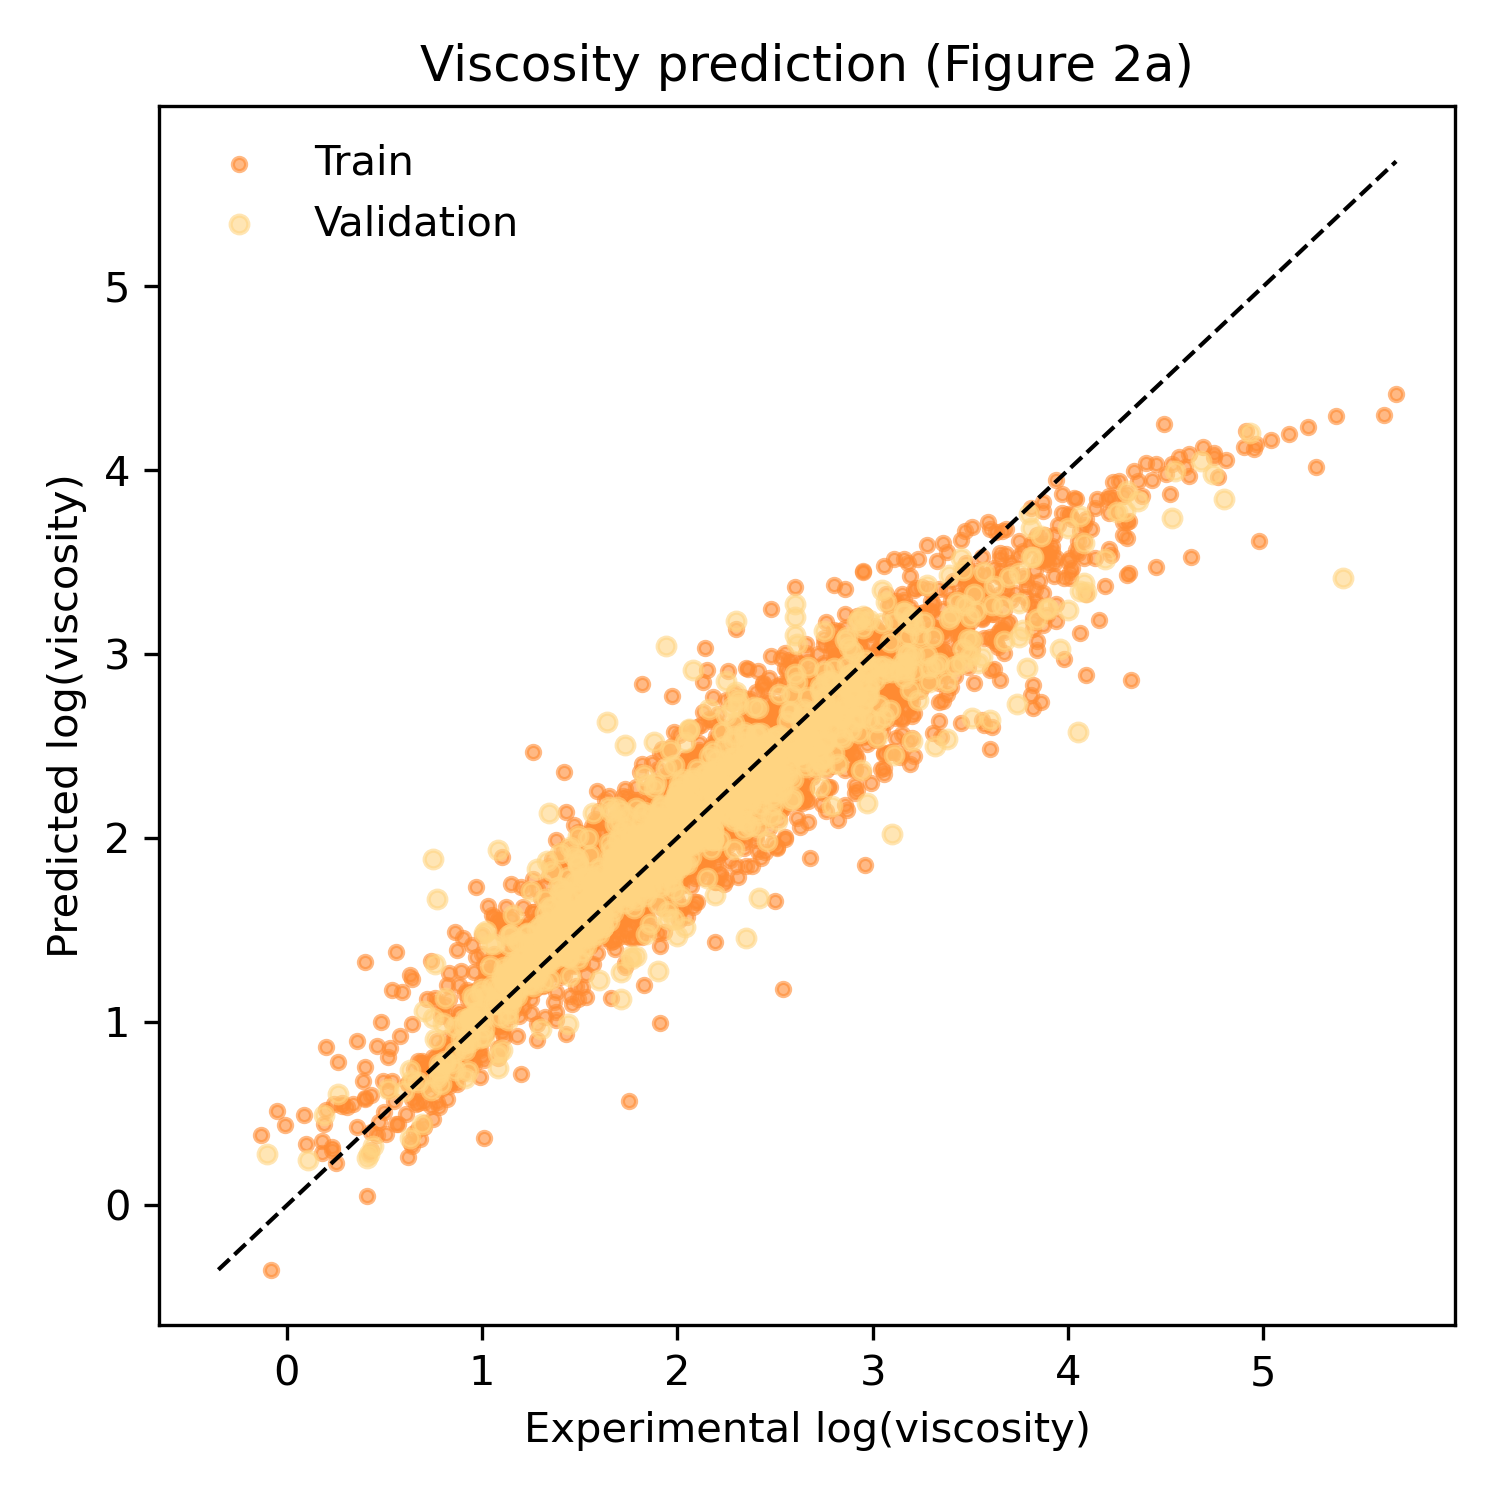

In [1]:
from IPython.display import Image, display

display(Image(filename="./results/figure2_a_viscosity.png"))


In [2]:
# Cell 1: 环境配置、导入库与辅助函数
# ------------------------------------------------------------
# 导入所需的库，配置环境变量以减少 TensorFlow 日志。
# 定义辅助函数 (r2_numpy, plot_loss) 和自定义日志回调 (SelectiveVerboseCallback)。
# ------------------------------------------------------------
import os 
# 设置环境变量，减少 TensorFlow 的日志输出
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0" 
os.environ["ABSL_LOG_LEVEL"] = "2" 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pickle
from pathlib import Path
import matplotlib.pyplot as plt

# --- 辅助函数 ---

def r2_numpy(y_true, y_pred):
    """计算 R^2 分数 (适用于 NumPy 数组)"""
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    if ss_tot == 0:
        return 0.0
    return 1 - (ss_res / ss_tot)

def plot_loss(history, save_path):
    """绘制训练和验证损失曲线"""
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss') 
    plt.title('Melting Point Model Loss (Scaled)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Saved loss plot to {save_path}")

# --- 自定义回调：仅在指定 epoch 输出日志 ---
class SelectiveVerboseCallback(keras.callbacks.Callback):
    def __init__(self, total_epochs, verbose_epochs=None):
        super().__init__()
        self.total_epochs = total_epochs
        if verbose_epochs is None:
            base = [1, 2, 3, 4, 5, 50, 100, 150, 200]
            last_five = list(range(total_epochs - 4, total_epochs + 1))
            self.verbose_epochs = set(base + last_five)
        else:
            self.verbose_epochs = set(verbose_epochs)

    def on_epoch_end(self, epoch, logs=None):
        current_epoch = epoch + 1
        if current_epoch in self.verbose_epochs:
            loss = logs.get('loss', 0)
            val_loss = logs.get('val_loss', 0)
            r2 = logs.get('r2_score', None)
            val_r2 = logs.get('val_r2_score', None)
            msg = f"Epoch {current_epoch}/{self.total_epochs} - loss: {loss:.6f} - val_loss: {val_loss:.6f}"
            if r2 is not None:
                msg += f" - r2: {r2:.4f} - val_r2: {val_r2:.4f}"
            print(msg)

In [3]:
# Cell 2: 模型核心组件 (Message Passing Layers)
# ------------------------------------------------------------
# 实现 MPNN 的关键操作：特征聚集、消息聚合和基于 GRUCell 的节点特征更新。
# ------------------------------------------------------------
# --- 核心模型组件 (GRUCell 调用修复) ---

class MessagePassingLayer(layers.Layer):
    """GRU 更新 h_v"""
    def __init__(self, fp_size, **kwargs):
        super(MessagePassingLayer, self).__init__(**kwargs)
        self.fp_size = fp_size
        self.gru = layers.GRUCell(fp_size, name='GRU')

    def call(self, inputs):
        h_t, m_t = inputs  # h_t: 当前节点特征, m_t: 聚合消息
        batch_size = tf.shape(h_t)[0]
        # flatten batch 和节点维度 (GRUCell 期望 (..., feature_size) 输入)
        h_flat = tf.reshape(h_t, (-1, self.fp_size))
        m_flat = tf.reshape(m_t, (-1, self.fp_size))
        
        # GRUCell 更新：返回 [new_output, new_state]
        h_new_flat = self.gru(m_flat, [h_flat])[0] 

        # reshape 回原来的 shape (batch, num_nodes, fp_size)
        h_new = tf.reshape(h_new_flat, (batch_size, -1, self.fp_size))
        return h_new


class GatherNeighborFeatureLayer(layers.Layer):
    """提取邻居节点特征 h_w (tf.gather 封装)"""
    def call(self, inputs):
        h_v, edge_input = inputs
        # edge_input[:, :, 1] 包含目标节点 (邻居) 的索引
        target_indices = edge_input[:, :, 1] 
        h_w = tf.gather(h_v, target_indices, batch_dims=1)
        return h_w


class GraphAggregationLayer(layers.Layer):
    """消息聚合层 (tf.scatter_nd 封装)"""
    def __init__(self, feature_size, **kwargs):
        super(GraphAggregationLayer, self).__init__(**kwargs)
        self.feature_size = feature_size
    
    def call(self, inputs):
        msg_vectors, start_indices, h_v = inputs
        
        batch_size = tf.shape(start_indices)[0]
        num_nodes = tf.shape(h_v)[1] 
        
        # 1. 构造用于 tf.scatter_nd 的扁平化索引 (batch_idx, node_idx)
        batch_indices = tf.range(batch_size)
        batch_indices = tf.expand_dims(batch_indices, axis=1)
        batch_indices = tf.tile(batch_indices, [1, tf.shape(start_indices)[1]])

        flat_indices = tf.stack([tf.reshape(batch_indices, [-1]), 
                                 tf.reshape(start_indices, [-1])], axis=1)
        
        # 2. 扁平化更新值 (消息向量)
        flat_updates = tf.reshape(msg_vectors, [-1, self.feature_size]) 
        
        # 3. 执行稀疏聚合 (将所有指向同一节点的消息向量求和)
        output_shape = (batch_size, num_nodes, self.feature_size)
        m_agg = tf.scatter_nd(
            indices=flat_indices, 
            updates=flat_updates, 
            shape=output_shape
        )
        return m_agg

In [4]:
# Cell 3: 构建 MPNN 模型结构
# ------------------------------------------------------------
# 定义 create_mpnn_base (Message Passing Steps 和指纹提取)。
# 定义 create_melting_point_model (双输入融合和预测头)。
# ------------------------------------------------------------

def get_vocab_sizes(vocab_path):
    """加载词汇表并返回原子和键特征的大小"""
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)
    # +1 是因为 padding 0 未在 vocab 中计数
    return vocab['atom_vocab_size'] + 1, vocab['bond_vocab_size'] + 1


def create_mpnn_base(atom_vocab_size, bond_vocab_size, params):
    """创建共享的 Message Passing Neural Network 基础架构。"""
    
    # --- 输入定义 ---
    atom_input = keras.Input(shape=(None,), dtype='int32', name='atom_ids')
    bond_input = keras.Input(shape=(None,), dtype='int32', name='bond_ids')
    # edge_input: (start_node, end_node)
    edge_input = keras.Input(shape=(None, 2), dtype='int32', name='edge_indices')
    
    # --- 嵌入层 ---
    atom_embedding = layers.Embedding(
        input_dim=atom_vocab_size, output_dim=params['atom_features_size'],
        name='atom_embedding'
    )
    # 键嵌入的维度是 atom_features_size * atom_features_size，用于消息矩阵
    bond_embedding = layers.Embedding(
        input_dim=bond_vocab_size, output_dim=params['atom_features_size'] * params['atom_features_size'], 
        name='bond_embedding'
    )

    h_v = atom_embedding(atom_input) # 初始节点特征
    
    for t in range(params['message_passing_steps']):
        # 1. 提取键特征作为消息矩阵 A_e
        A_e = bond_embedding(bond_input)
        
        # 1.1 提取相邻原子的特征 h_w
        h_w = GatherNeighborFeatureLayer(name=f'Gather_step_{t}')([h_v, edge_input]) 

        # 2. 消息向量计算: m_uv = A_e * h_w
        def compute_msg_vectors(inputs):
            A_e_inner, h_w_inner = inputs
            # 重塑 A_e 为 (batch, num_edges, d_atom, d_atom)
            A_e_reshaped = tf.reshape(A_e_inner, (-1, tf.shape(A_e_inner)[1], params['atom_features_size'], params['atom_features_size']))
            h_w_reshaped = tf.expand_dims(h_w_inner, axis=-1) # (batch, num_edges, d_atom, 1)
            msg_vectors_inner = tf.matmul(A_e_reshaped, h_w_reshaped)
            return tf.squeeze(msg_vectors_inner, axis=-1) # (batch, num_edges, d_atom)

        msg_vectors = layers.Lambda(compute_msg_vectors, name=f'Msg_step_{t}')([A_e, h_w])

        # 3. 聚合消息 m_t+1 = SUM(m_uv)
        m_t_plus_1 = GraphAggregationLayer(
            feature_size=params['atom_features_size'], 
            name=f'Agg_step_{t}'
        )([msg_vectors, edge_input[:, :, 0], h_v]) # edge_input[:, :, 0] 是起始节点索引 (用于聚合)
        
        # 4. GRU 更新 h_v
        h_v = MessagePassingLayer(params['atom_features_size'], name=f'MP_step_{t}')([h_v, m_t_plus_1])
        
    # 5. 分子指纹生成 (节点特征通过 Dense 层，然后全局求和)
    fp_regression_layer = layers.Dense(params['fingerprint_size'], activation='relu', name='fp_regression')
    fp_vector = fp_regression_layer(h_v)
    mol_fingerprint = layers.Lambda(lambda x: tf.reduce_sum(x, axis=1), name='molecular_fingerprint')(fp_vector)
    
    return keras.Model(inputs=[atom_input, bond_input, edge_input], outputs=mol_fingerprint, name='MPNN_Base')


def create_melting_point_model(atom_vocab_size, bond_vocab_size, params):
    """创建完整的熔点预测模型。"""
    
    mpnn_base = create_mpnn_base(atom_vocab_size, bond_vocab_size, params)
    
    # --- 输入定义（两个离子）---
    cat_inputs = [keras.Input(shape=(None,), dtype='int32', name='cat_atom_ids'),
                  keras.Input(shape=(None,), dtype='int32', name='cat_bond_ids'),
                  keras.Input(shape=(None, 2), dtype='int32', name='cat_edge_indices')]
    an_inputs = [keras.Input(shape=(None,), dtype='int32', name='an_atom_ids'),
                 keras.Input(shape=(None,), dtype='int32', name='an_bond_ids'),
                 keras.Input(shape=(None, 2), dtype='int32', name='an_edge_indices')]
    
    # 2. 通过共享的 MPNN Base 获取分子指纹
    cat_fp = mpnn_base(cat_inputs)
    an_fp = mpnn_base(an_inputs)
    
    # 3. 独立密集层
    cat_dense = layers.Dense(params['mixing_size'], activation='relu', name='cation_pre_mix_dense')(cat_fp)
    an_dense = layers.Dense(params['mixing_size'], activation='relu', name='anion_pre_mix_dense')(an_fp)
    
    # 4. 组合（Sum）
    combined_fp = layers.Add(name='mixing_layer')([cat_dense, an_dense])
    
    # 5. 预测头
    head = layers.Dense(params['mixing_size'], activation='relu', name='mp_head_1')(combined_fp)
    output = layers.Dense(1, activation='linear', name='mp_output')(head) # 线性激活，用于回归
    
    model = keras.Model(inputs=cat_inputs + an_inputs, outputs=output, name='Melting_Point_MPNN')
    
    return model

In [5]:
# Cell 4: 数据加载、划分与标准化
# ------------------------------------------------------------
# 定义数据路径和超参数。
# 实现数据加载、70%/15%/15% 划分逻辑。
# 对目标标签 (熔点) 进行标准化处理 (基于训练集均值和标准差)。
# ------------------------------------------------------------

# --- 配置和数据路径 (假设在运行环境中，代码文件在 ionic-mpnn/train/ 下) ---
BASE_DIR = Path('.') # 假设当前目录是脚本的执行目录
DATA_DIR = BASE_DIR / 'data' 
RESULTS_DIR = BASE_DIR / 'results'
MP_DATA_PATH = DATA_DIR / 'mp_id_data.pkl'
VOCAB_PATH = DATA_DIR / 'vocab.pkl'

# 默认 Hyperparams
HYPERPARAMS = {
    'atom_features_size': 32, 
    'fingerprint_size': 32,   
    'mixing_size': 20,        
    'message_passing_steps': 4, 
    'learning_rate_initial': 0.01,
    'learning_rate_decay_factor': 0.55, 
    'decay_step': 100,
    'epochs': 1000,
    'batch_size': 32, 
}

# 创建目录
RESULTS_DIR.mkdir(exist_ok=True)
Path(BASE_DIR / "models").mkdir(exist_ok=True)


def load_and_prepare_data(data_path):
    """加载 mp_id_data.pkl 并进行 70%/15%/15% 的训练/验证/测试分割, 并标准化 Y 标签。"""
    try:
        with open(data_path, 'rb') as f:
            data = pickle.load(f)
    except FileNotFoundError:
        print(f"错误: 找不到数据文件 {data_path}")
        return None, None, None, None
        
    print(f"原始数据集大小: {len(data)} 条记录")
        
    # 提取输入和标签 (Y 是原始的未标准化熔点值)
    X_cat_atom = [np.array(r['cation']['atom_ids']) for r in data]
    X_cat_bond = [np.array(r['cation']['bond_ids']) for r in data]
    X_cat_edge = [np.array(r['cation']['edge_indices']) for r in data]
    X_an_atom = [np.array(r['anion']['atom_ids']) for r in data]
    X_an_bond = [np.array(r['anion']['bond_ids']) for r in data]
    X_an_edge = [np.array(r['anion']['edge_indices']) for r in data]
    Y_unscaled_all = np.array([r['mp'] for r in data]) 
    
    # 对齐形状 (Padding)
    X_cat_atom = keras.preprocessing.sequence.pad_sequences(X_cat_atom, padding='post', value=0)
    X_cat_bond = keras.preprocessing.sequence.pad_sequences(X_cat_bond, padding='post', value=0)
    X_cat_edge = keras.preprocessing.sequence.pad_sequences(X_cat_edge, padding='post', value=[0, 0])
    X_an_atom = keras.preprocessing.sequence.pad_sequences(X_an_atom, padding='post', value=0)
    X_an_bond = keras.preprocessing.sequence.pad_sequences(X_an_bond, padding='post', value=0)
    X_an_edge = keras.preprocessing.sequence.pad_sequences(X_an_edge, padding='post', value=[0, 0])

    X_all = [X_cat_atom, X_cat_bond, X_cat_edge, X_an_atom, X_an_bond, X_an_edge]
    
    # 70%/15%/15% 划分索引
    total_size = len(data)
    train_end_idx = int(total_size * 0.70)
    val_end_idx = int(total_size * 0.85) 
    
    # --- Y 标签标准化 (基于训练集统计量) ---
    Y_train_unscaled = Y_unscaled_all[:train_end_idx]
    
    Y_mean = np.mean(Y_train_unscaled)
    Y_std = np.std(Y_train_unscaled)
    if Y_std == 0: Y_std = 1.0 

    Y_scaled_all = (Y_unscaled_all - Y_mean) / Y_std
    
    # --- 集合划分 ---
    X_train = [X_all[i][:train_end_idx] for i in range(len(X_all))]
    Y_train_scaled = Y_scaled_all[:train_end_idx]
    Y_train_unscaled = Y_unscaled_all[:train_end_idx]

    X_dev = [X_all[i][train_end_idx:val_end_idx] for i in range(len(X_all))]
    Y_dev_scaled = Y_scaled_all[train_end_idx:val_end_idx]
    Y_dev_unscaled = Y_unscaled_all[train_end_idx:val_end_idx]

    X_test = [X_all[i][val_end_idx:] for i in range(len(X_all))]
    Y_test_scaled = Y_scaled_all[val_end_idx:]
    Y_test_unscaled = Y_unscaled_all[val_end_idx:]

    print(f"数据划分完成: Train={len(Y_train_scaled)}, Dev={len(Y_dev_scaled)}, Test={len(Y_test_scaled)}")
    print(f"标签标准化参数: Mean={Y_mean:.4f}, Std={Y_std:.4f}")

    return (X_train, Y_train_scaled, Y_train_unscaled), \
           (X_dev, Y_dev_scaled, Y_dev_unscaled), \
           (X_test, Y_test_scaled, Y_test_unscaled), \
           {'mean': Y_mean, 'std': Y_std}

# 执行数据加载和准备
(X_train, Y_train_s, Y_train_u), \
(X_dev, Y_dev_s, Y_dev_u), \
(X_test, Y_test_s, Y_test_u), \
scaling_params = load_and_prepare_data(MP_DATA_PATH)

原始数据集大小: 2212 条记录
数据划分完成: Train=1548, Dev=332, Test=332
标签标准化参数: Mean=94.1453, Std=82.2600


In [6]:
# Cell 5: 模型编译、训练与保存
# ------------------------------------------------------------
# 实例化 MPNN 模型，设置学习率调度器，并编译模型。
# 使用 EarlyStopping 和自定义 SelectiveVerboseCallback 进行模型训练。
# 训练结束后，保存最优模型权重和损失曲线。
# ------------------------------------------------------------

if X_train is not None:
    # 1. 加载词汇表
    atom_size, bond_size = get_vocab_sizes(VOCAB_PATH)
    
    # 2. 创建模型
    model = create_melting_point_model(atom_size, bond_size, HYPERPARAMS)
    
    # 3. 定义学习率调度器 (基于训练样本数和 batch size)
    decay_steps = len(X_train[0]) / HYPERPARAMS['batch_size'] * HYPERPARAMS['decay_step']
    lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
        initial_learning_rate=HYPERPARAMS['learning_rate_initial'],
        decay_steps=decay_steps,
        decay_rate=1 - HYPERPARAMS['learning_rate_decay_factor'] # 1 - 0.55 = 0.45
    )
    
    # 4. 编译模型 
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss='mean_squared_error',
        metrics=[keras.metrics.R2Score(name='r2_score')]
    )

    # model.summary() # 可以在 Jupyter 中取消注释查看模型结构

    # 5. 训练
    print("\n" + "="*50)
    print("--- 熔点模型训练开始 (Loss 在标准化尺度上) ---")
    
    total_epochs = HYPERPARAMS['epochs']
    history = model.fit(
        X_train, Y_train_s, # 使用标准化的 Y 进行训练
        validation_data=(X_dev, Y_dev_s),
        epochs=total_epochs,
        batch_size=HYPERPARAMS['batch_size'],
        callbacks=[
            keras.callbacks.EarlyStopping(patience=50, monitor='val_loss', restore_best_weights=True),
            SelectiveVerboseCallback(total_epochs=total_epochs)
        ],
        verbose=0
    )
    
    # 6. 保存模型和损失曲线
    models_dir = BASE_DIR / "models"
    model.save(models_dir / "melting_point_final.keras", save_format="keras_v3")
    print(f"\nSaved melting point model to {models_dir / 'melting_point_final.keras'}")

    plot_loss(history, RESULTS_DIR / "loss_melting_point.png")
else:
    print("跳过训练：数据加载失败。")


--- 熔点模型训练开始 (Loss 在标准化尺度上) ---


I0000 00:00:1765702070.080533  990220 service.cc:145] XLA service 0x2239a6c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765702070.080596  990220 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1765702074.420418  990220 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_11', 36 bytes spill stores, 36 bytes spill loads

I0000 00:00:1765702074.427294  990220 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
I0000 00:00:1765702077.488315  990215 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_11', 36 bytes spill stores, 36 bytes spill loads



Epoch 1/1000 - loss: 3.070855 - val_loss: 0.581448 - r2: -2.0709 - val_r2: 0.0998
Epoch 2/1000 - loss: 0.595532 - val_loss: 0.520880 - r2: 0.4045 - val_r2: 0.1936
Epoch 3/1000 - loss: 0.495399 - val_loss: 0.535005 - r2: 0.5046 - val_r2: 0.1717
Epoch 4/1000 - loss: 0.473528 - val_loss: 0.557575 - r2: 0.5265 - val_r2: 0.1368
Epoch 5/1000 - loss: 0.464144 - val_loss: 0.688211 - r2: 0.5359 - val_r2: -0.0655
Epoch 50/1000 - loss: 0.326020 - val_loss: 0.488852 - r2: 0.6740 - val_r2: 0.2432
Epoch 100/1000 - loss: 0.327068 - val_loss: 0.583279 - r2: 0.6729 - val_r2: 0.0970



Saved melting point model to models/melting_point_final.keras
Saved loss plot to results/loss_melting_point.png


In [7]:
# Cell 6: 结果评估与绘图
# ------------------------------------------------------------
# 使用模型对 Train, Dev, Test 集进行预测。
# 将预测结果进行反标准化，并使用原始尺度计算 R2 和 MAE。
# 绘制最终的散点图 (Figure 2b)。
# ------------------------------------------------------------

def plot_melting_point_prediction(model, X_train, Y_train_unscaled, X_dev, Y_dev_unscaled, scaling_params):
    """生成熔点预测的散点图 (Figure 2b)，使用原始未标准化值。"""
    Y_mean = scaling_params['mean']
    Y_std = scaling_params['std']
    
    # 预测 (模型返回 scaled values)
    y_train_pred_scaled = model.predict(X_train, verbose=0).flatten()
    y_dev_pred_scaled   = model.predict(X_dev, verbose=0).flatten()
    
    # 反标准化预测结果
    y_train_pred_unscaled = y_train_pred_scaled * Y_std + Y_mean
    y_dev_pred_unscaled   = y_dev_pred_scaled * Y_std + Y_mean
    
    Y_train = Y_train_unscaled
    Y_dev = Y_dev_unscaled
    y_train_pred = y_train_pred_unscaled
    y_dev_pred = y_dev_pred_unscaled
    
    plt.figure(figsize=(5, 5))

    # Train: 深蓝色 
    plt.scatter(
        Y_train, y_train_pred, s=10, alpha=0.6, color="#0000FF", label="Train"
    )

    # Dev (Validation): 浅蓝色 
    plt.scatter(
        Y_dev, y_dev_pred, s=18, alpha=0.6, color="#A4C1F7", label="Validation"
    )

    # y = x reference line
    all_y = np.concatenate([Y_train, Y_dev, y_train_pred, y_dev_pred])
    low = all_y.min() - 0.1
    high = all_y.max() + 0.1
    plt.plot([low, high], [low, high], "k--", linewidth=1)

    plt.xlabel("Experimental Melting Point")
    plt.ylabel("Predicted Melting Point")
    plt.title("Melting Point prediction (Figure 2b)")

    plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / "figure2_b_melting_point.png", dpi=300)
    plt.close()
    print(f"\n熔点预测散点图 (使用原始尺度值) 已保存到: {RESULTS_DIR / 'figure2_b_melting_point.png'}")


if 'model' in locals() and X_train is not None:
    print("\n--- 熔点模型最终评估 (R2 和 MAE 在原始尺度上报告) ---")
    Y_mean = scaling_params['mean']
    Y_std = scaling_params['std']
    
    Y_sets = {
        "Train": (X_train, Y_train_u),
        "Dev":   (X_dev, Y_dev_u),
        "Test":  (X_test, Y_test_u)
    }
    
    for name, (X_, Y_unscaled) in Y_sets.items():
        # 1. 预测标准化值
        pred_scaled = model.predict(X_, verbose=0).flatten()
        
        # 2. 反标准化预测值
        pred_unscaled = pred_scaled * Y_std + Y_mean
        
        # 3. 使用原始未标准化值计算 R2 和 MAE
        print(
            f"{name}: R2={r2_numpy(Y_unscaled, pred_unscaled):.4f}, "
            f"MAE={np.mean(np.abs(Y_unscaled - pred_unscaled)):.4f}"
        )
    
    # 4. 绘制结果图 (仅 Train + Dev)
    plot_melting_point_prediction(model, X_train, Y_train_u, X_dev, Y_dev_u, scaling_params)
else:
    print("跳过评估和绘图：模型或数据未成功加载。")


--- 熔点模型最终评估 (R2 和 MAE 在原始尺度上报告) ---
Train: R2=0.6229, MAE=39.5668
Dev: R2=0.4497, MAE=34.9370
Test: R2=0.1966, MAE=37.9011

熔点预测散点图 (使用原始尺度值) 已保存到: results/figure2_b_melting_point.png


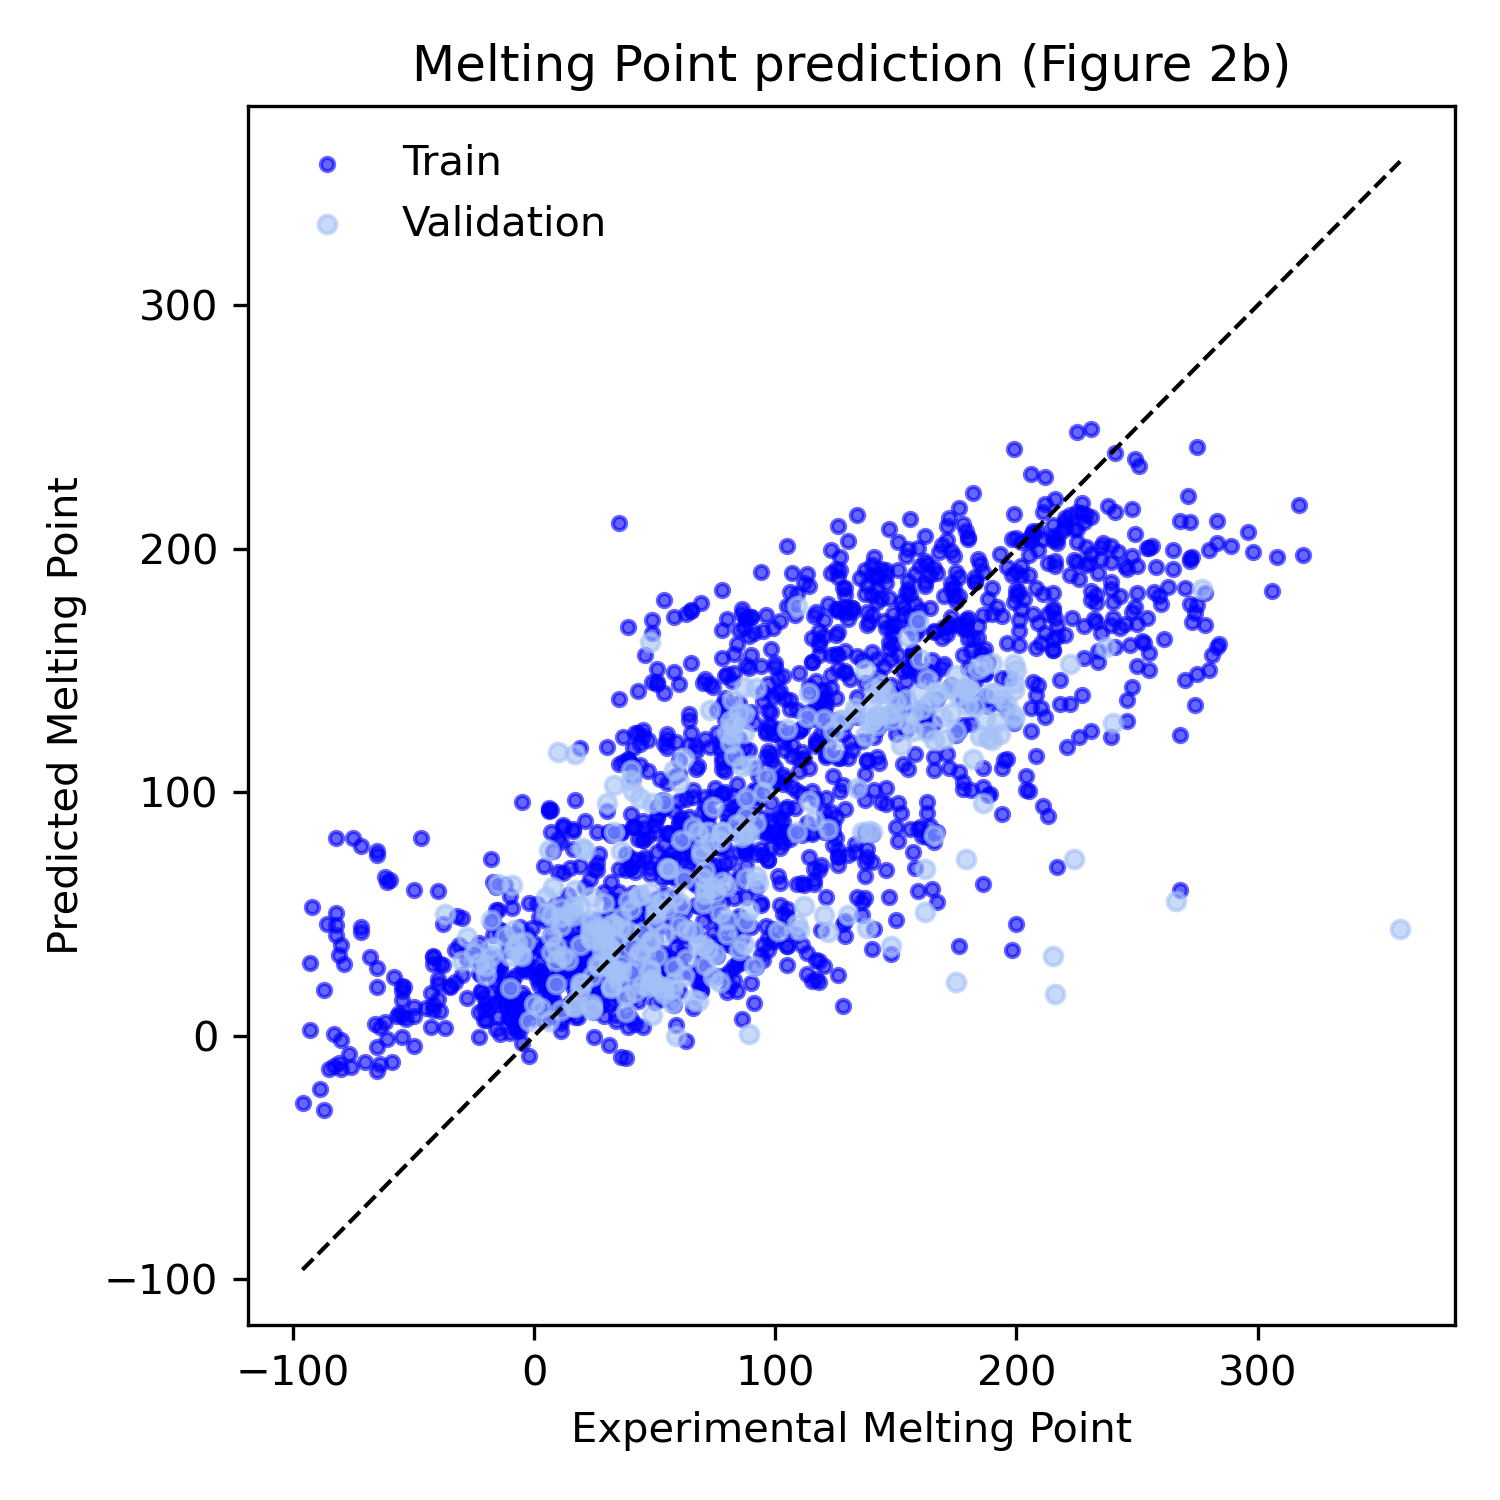

In [8]:
from IPython.display import Image, display

display(Image(filename="./results/figure2_b_melting_point.png"))
